In [1]:
from data import *
from model import *

taxi_type = GREEN
train_sql = getSqlForModeling(taxi_type, isTrain=True)

df = getDF(train_sql)
X_train, y_train = df[FEATURES], df[VARIABLE]

sql engine ready


In [2]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_dist = {
    "n_estimators": [900, 1000, 1100],
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth": [7, 9, 11],
    "subsample": [0.8, 1.0],
}

# Model and Randomized Search
xgb = XGBRegressor()
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=50, cv=3, scoring="neg_mean_squared_error", verbose=1)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 11, 'learning_rate': 0.01}
Best Score: -5.322897208316287


In [3]:
from xgboost import XGBRegressor
from data import *
from model import *

taxi_type = GREEN
train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = XGBRegressor(n_estimators=1000, 
                     learning_rate=0.1, 
                     max_depth=9, 
                     n_iter_no_change=10)

# Training
with DR.engn.connect() as conn:
    processed = 0
    for df in pd.read_sql(train_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y = df[VARIABLE]

        model.fit(X, y)
        O.out(f'Trained {processed} rows')

storeModel(model, f'{taxi_type}_{VARIABLE}_{XGB_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_test = []
    y_pred = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        y_test.append(df[VARIABLE])

        y_pred.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
merged_y_test = pd.concat(y_test, ignore_index=True)
merged_y_pred = np.concatenate(y_pred)

showPerformance(merged_y_test, merged_y_pred)

Traceback (most recent call last):
  File "/Users/njpate/Library/Python/3.9/lib/python/site-packages/IPython/core/completer.py", line 3171, in _complete
    result = matcher(context)
  File "/Users/njpate/Library/Python/3.9/lib/python/site-packages/IPython/core/completer.py", line 2099, in magic_matcher
    matches = self.magic_matches(text)
  File "/Users/njpate/Library/Python/3.9/lib/python/site-packages/IPython/core/completer.py", line 2132, in magic_matches
    global_matches = self.global_matches(bare_text)
  File "/Users/njpate/Library/Python/3.9/lib/python/site-packages/IPython/core/completer.py", line 1113, in global_matches
    for word in lst:
RuntimeError: dictionary changed size during iteration


NameError: name 'XGB_REGRESSOR' is not defined

In [5]:
# model
storeModel(model, f'{taxi_type}_{VARIABLE}_xgb_regressor')

In [ ]:
from model import *

data = readData(taxi_type=GREEN)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = data[FEATURES_SET1]
y = data[VARIABLE]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Gradient Boosting Model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, 
                                #   validation_fraction=0.1, 
                                  n_iter_no_change=10,      
                                  max_depth=9, 
                                  # random_state=42
                                  )
model.fit(X_train, y_train)

# 5. Predictions
y_pred = model.predict(X_test)



In [ ]:
param_grid = {
    "n_estimators": [950, 1000, 1050],
    "learning_rate": [0.1, 0.09, 0.11],
    "max_depth": [8, 9, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.6, 0.8, 1.0]
}

# Perform grid search
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring="r2",  # Optimize for R-squared
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import plotly.graph_objects as go

# Calculate Model Accuracy Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Accuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (Accuracy): {r2:.2f}")

# Limit data to 150 samples for visualization
samples_to_plot = 150
y_test_limited = y_test[:samples_to_plot].reset_index(drop=True)
y_pred_limited = y_pred[:samples_to_plot]

# Create Line Chart with Plotly
fig = go.Figure()

# Actual Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_test_limited, 
    mode="lines+markers", 
    name="Actual",
    line=dict(color="blue")
))

# Predicted Values
fig.add_trace(go.Scatter(
    x=y_test_limited.index, 
    y=y_pred_limited, 
    mode="lines+markers", 
    name="Predicted",
    line=dict(color="orange")
))

# Customize Layout
fig.update_layout(
    title="Actual vs Predicted Fare Amount (Limited to 150 Samples)",
    xaxis_title="Sample Index",
    yaxis_title="Fare Amount ($)",
    legend=dict(x=0.5, y=1.15, xanchor="center", yanchor="top"),
    template="plotly_white"
)

# Show the plot
fig.show()


sql engine ready
Mean Squared Error: 8.140811792897876


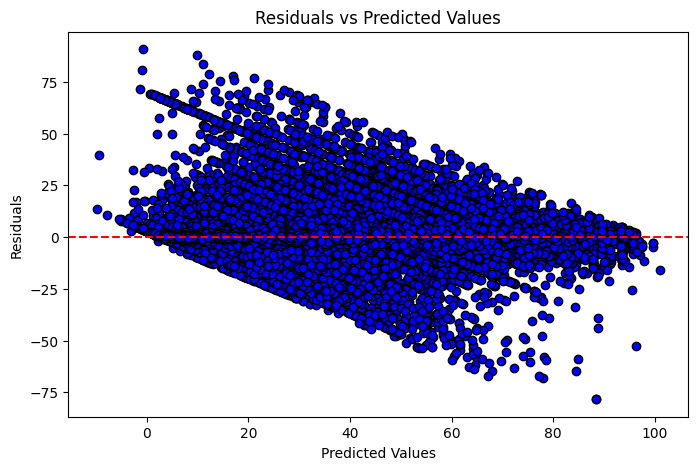

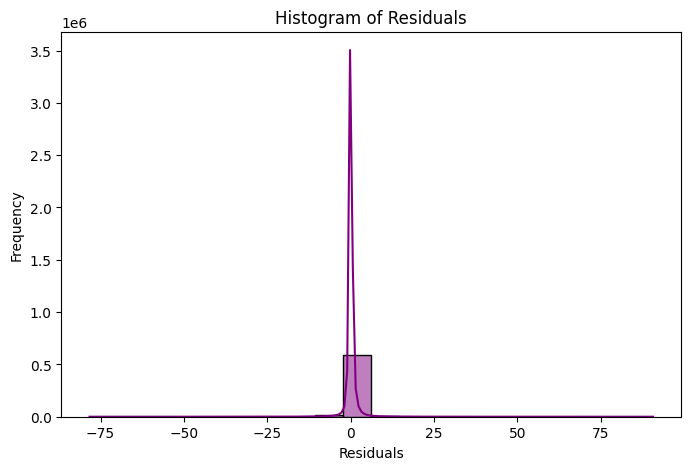

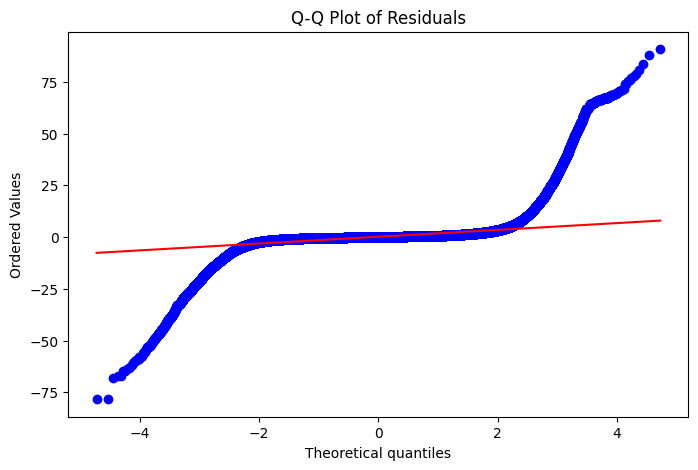

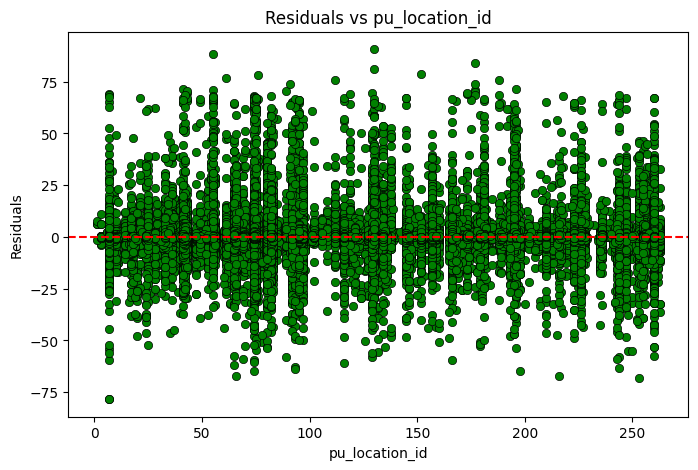

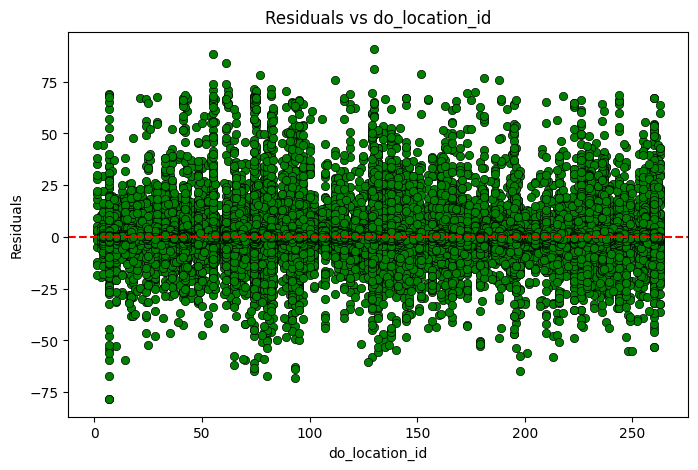

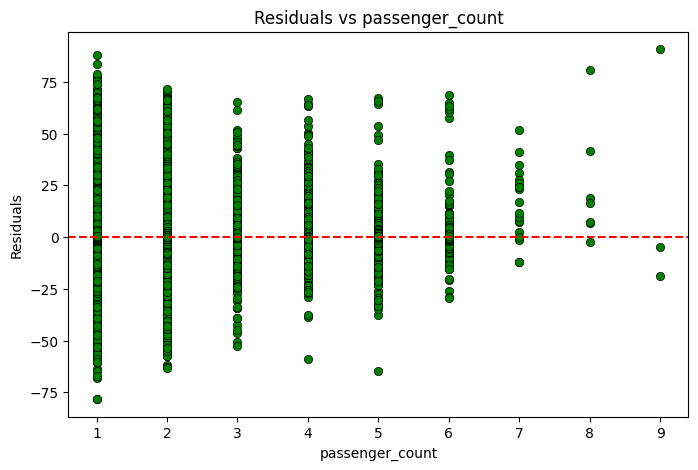

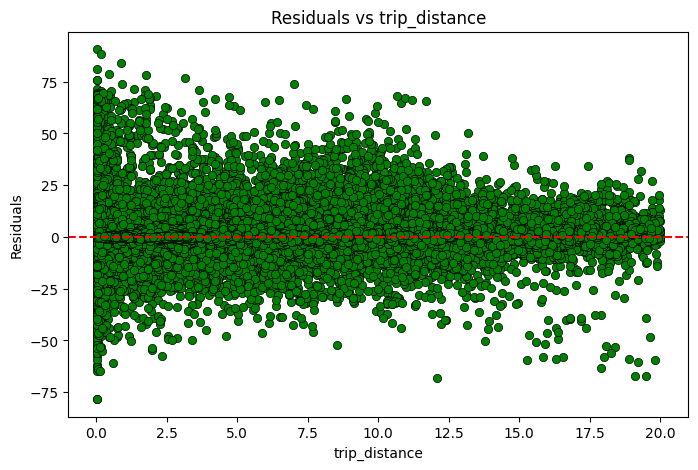

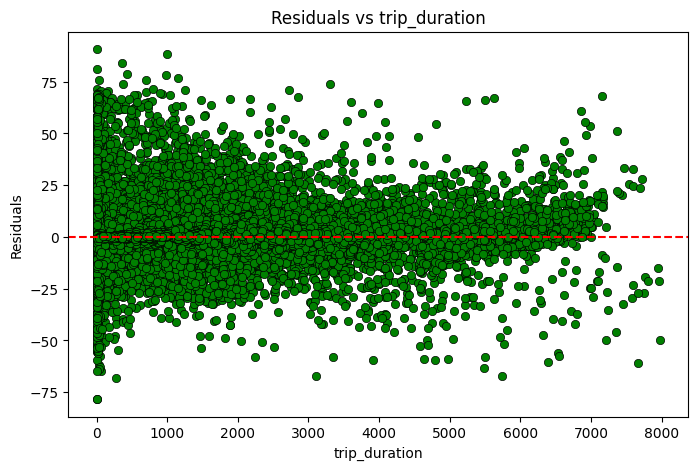

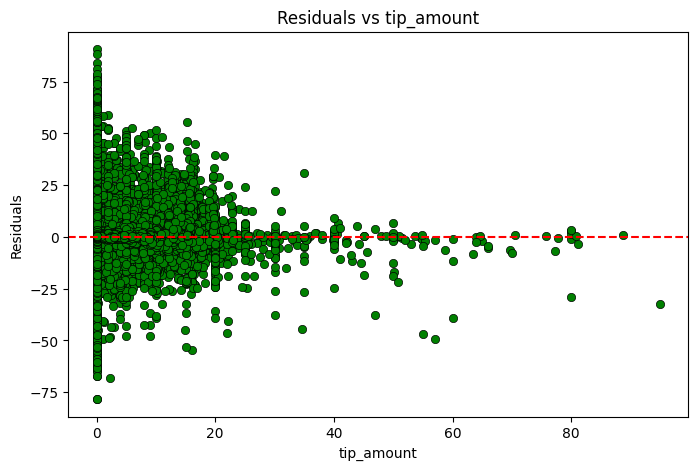

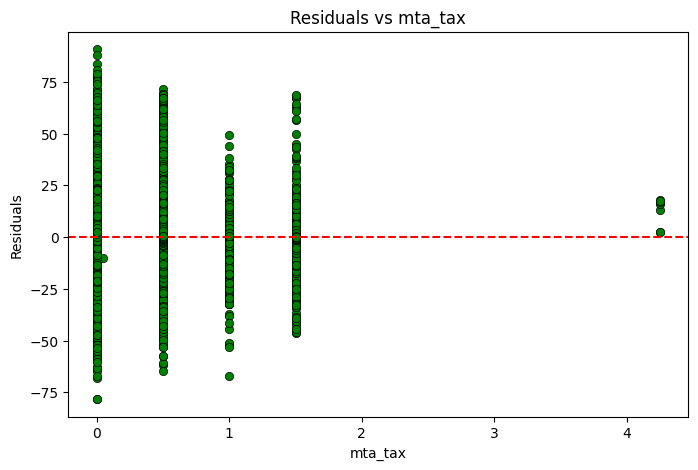

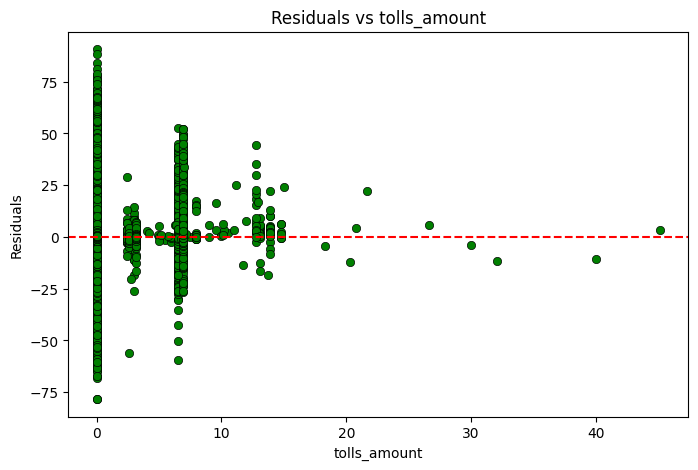

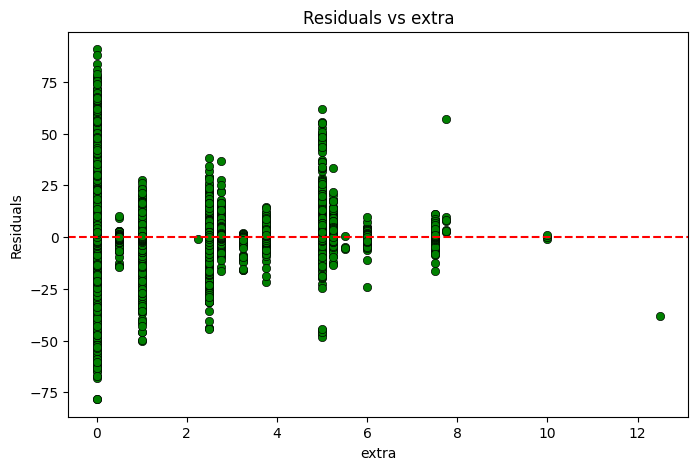

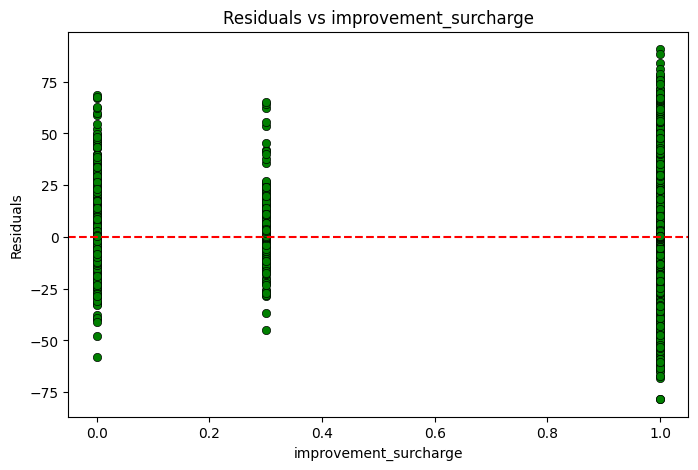

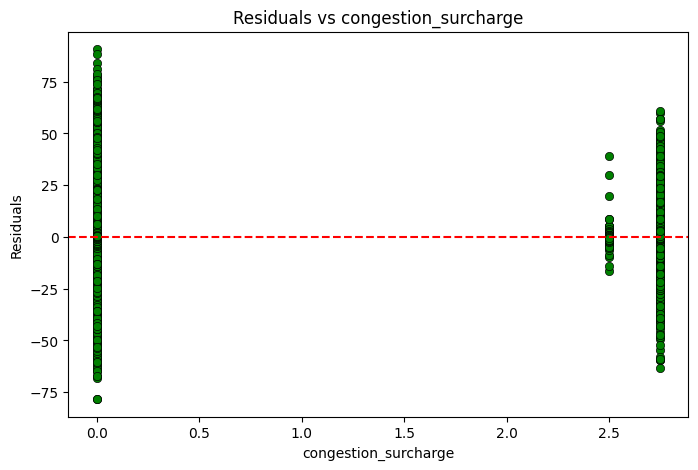

In [1]:
# Residual Analysis
from data import *
from model import *

taxi_type = GREEN
# train_sql = getSqlForModeling(taxi_type, isTrain=True)
test_sql = getSqlForModeling(taxi_type, isTrain=False)

model = loadModel(f'{taxi_type}_{VARIABLE}_{XGB_REGRESSOR}')

# Predictions
with DR.engn.connect() as conn:
    processed = 0
    y_t_chunk = []
    y_p_chunk = []
    X_t_chunk = []
    for df in pd.read_sql(test_sql, conn, chunksize=CHUNK_SIZE):
        processed += len(df)
        X = df[FEATURES]
        X_t_chunk.append(X)
        y_t_chunk.append(df[VARIABLE])

        y_p_chunk.append(model.predict(X))
        O.out(f'Predicted {processed} rows')

# Performance
X_test = pd.concat(X_t_chunk, ignore_index=True)
y_test = pd.concat(y_t_chunk, ignore_index=True)
y_pred = np.concatenate(y_p_chunk)


residualAnalysis(X_test, y_test, y_pred)